## Module 3 Coding Assignment: Creating features from a price series.
We will explore creating features using price series.


1.	**Download USO.csv which contains the daily bars of the US Oil Fund. Use our provided functions getWeights_FFD, fractDiff.FFD, and findMinD, to find the minimum fractionaldimension d that will turn this price series into a stationary series.**

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [2]:
def getWeights_FFD(d,thres):
  w,k=[1.],1
  while True:
    w_=-w[-1]/k*(d-k+1)
    if abs(w_)<thres:break
    w.append(w_);k+=1
  return np.array(w[::-1]).reshape(-1,1)

In [3]:
def fracDiff_FFD(series,d,thres=1e-5):
# Constant width window (new solution)
  w=getWeights_FFD(d,thres)
  df={}
  for name in series.columns:
    df_=pd.Series(series[name].values,index=series.index).fillna(method='ffill').dropna()
    x=pd.Series(0,index=df_.index)
    for k in range(w.shape[0]):
      x=x+w[k,0]*df_.shift(-k)
  #df[name]=x.dropna().copy(deep=True)
  df[name]=x.shift(k).copy(deep=True)
  df=pd.concat(df,axis=1)
  return df


In [4]:
def findMinD(series):
  for d in np.linspace(0,1,11):
    df_=fracDiff_FFD(series,d,thres=0.01).dropna()
    res=adfuller(df_.iloc[:,0].values,maxlag=1,regression='c',autolag=None)
    if (res[0]<=res[4]['5%']):
      return d
  return 1.0

In [5]:
df=pd.read_csv('./USO.CSV')
df.columns=df.columns.str.replace(' ','')


FileNotFoundError: [Errno 2] No such file or directory: '/content/USO.CSV'

In [ ]:
logUSO=pd.DataFrame(np.log(df['Close'])) # Must use log prices for FD

In [ ]:
d=findMinD(logUSO)
d

0.5

2.	**Using the d you found in part 1 to fractionally differentiate the USO daily price series. Use adfuller from statsmodels.tsa.stattools to determine the ADF statistics of theresulting time series. Can you conclude from these statistics that the fractionally differentiated time series is stationary?**

In [6]:
logUSO_FD=fracDiff_FFD(logUSO,d,thres=0.01)
plt.plot(logUSO_FD)

NameError: name 'logUSO' is not defined

In [ ]:
results=adfuller(np.array(logUSO_FD[logUSO_FD['Close'].notnull()]['Close']), maxlag=1, regression='c', autolag=None)
print(results)


(-3.7566886200195397, 0.0033828660986459946, 1, 3297, {'1%': -3.4323349555967604, '5%': -2.862417036057391, '10%': -2.5672368644181542})


**Solution**: Since 3.75 > 3.432 we confirm stationarity

3.	**Complete Execise 5.1 in AFML using the functions we provided.**
Generate a time series from an IID Gaussian random process. This is a memoryless, stationary series:

* Compute the ADF statistic on this series. What is the p-value?
* Compute the cumulative sum of the observations. This is a non-stationary series without memory.
** What is the order of integration of this cumulative series?
Compute the ADF statistic on this series.
** What is the p-value?
*	Differentiate the series twice. What is the p-value of this over-differentiated series?


<Axes: >

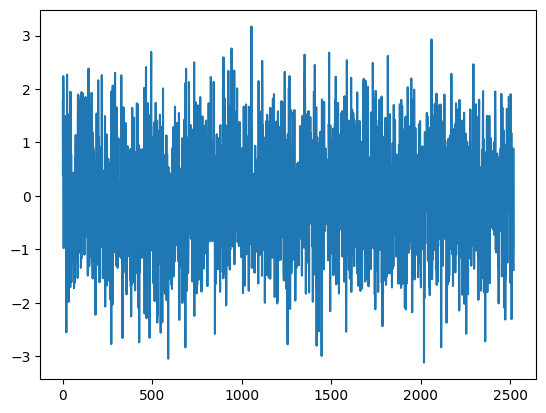

In [ ]:

np.random.seed(0)
N = 252*10
s = pd.Series(np.random.randn(N))
s.plot()


In [ ]:
# part (1)
import statsmodels.api as sm
adf = lambda s: sm.tsa.stattools.adfuller(s)
p_val = lambda s: sm.tsa.stattools.adfuller(s)[1]
res = adf(s); p = res[1]
print(res)
print("--------------")
print(p)


(-50.80332180276013, 0.0, 0, 2519, {'1%': -3.4329486408391174, '5%': -2.8626880695259413, '10%': -2.567381161224712}, 6950.968131407137)
--------------
0.0


<Axes: >

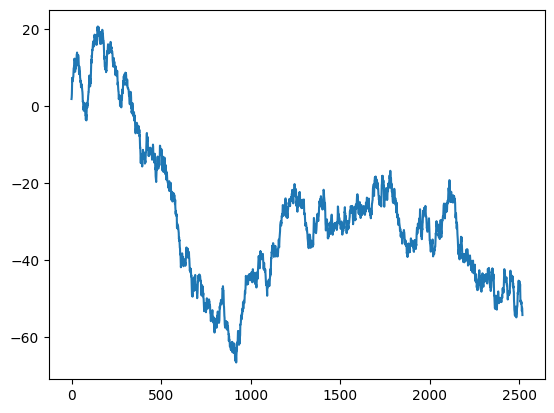

In [ ]:
# part (2)
cmsm = pd.Series(s).cumsum()
cmsm.plot()


In [ ]:
# 2.1
orders = [0, 1, 2, 3, 4]
for o in orders:
 diff_ = np.diff(cmsm,o)
 print('='*27)
 print(f'order: {o}, pVal: {p_val(diff_)}')


order: 0, pVal: 0.5704444806659968
order: 1, pVal: 0.0
order: 2, pVal: 7.347529850651771e-30
order: 3, pVal: 0.0
order: 4, pVal: 0.0


The concept of stationarity with p value is such that if p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is nonstationary. p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary. Thus the order is 1 since the P value then becomes <=0.05

In [ ]:
# 2.2
p_val(cmsm)


0.5704444806659968

In [ ]:
# (3)
d=findMinD(cmsm.to_frame())
cmsm_FD=fracDiff_FFD(cmsm.to_frame(),d,thres=0.01)
print("Frac Differentiated d : {} and thus p_val of differentiated series : {}".format(d,p_val(cmsm_FD.dropna())) )
d1=findMinD(cmsm_FD.dropna())
cmsm_FD1=fracDiff_FFD(cmsm_FD.dropna(),d,thres=0.01)
print("Frac Differentiated d : {} and thus p_val of differentiated series : {}".format(d1,p_val(cmsm_FD1.dropna())) )


Frac Differentiated d : 0.30000000000000004 and thus p_val of differentiated series : 0.34163805860028285
Frac Differentiated d : 0.0 and thus p_val of differentiated series : 0.30001093226673525


4. **Can you tell the difference between the functions we provided vs the ones provided in Chapter 5 of AFML? How much time do they take to run for parts 2) and 3) respectively?**

In the function provided compared to the function in the Chap 5 of AFML we can find one place that is the for loop is changed where the .shift function is used rather than iterating over the each values with the iloc function as provided in the Chap 5 of AFML.

Code Provided by Us:

```
for name in series.columns:
        df_=pd.Series(series[name].values,index=series.index).fillna(method='ffill').dropna()         
        x=pd.Series(0,index=df_.index)
        for k in range(w.shape[0]):             
          x=x+w[k,0]*df_.shift(-k)
```
   
Code in AFML:

```
for name in series.columns:
  seriesF,df_=series[[name]].fillna(method='ffill').dropna(),pd.Series()
for iloc1 in range(width,seriesF.shape[0]):
  loc0,loc1=seriesF.index[iloc1-width],seriesF.index[iloc1]
if not np.isfinite(series.loc[loc1,name]):
  continue # exclude NAs
df_[loc1]=np.dot(w.T,seriesF.loc[loc0:loc1])[0,0]

```
The Code provided by Dr. Ernst P Chan and Dr. Roger Hunter does the calculation in seconds while the one in the book takes some time which could run into months or even years depending on the size of data.
